In [1]:
import processes.cosmology as cosmology
import processes.synchro as synchro
import processes.ic as ic
import processes.spectra as spec
import processes.ebl as ebl
import processes.gamma_gamma as gamma_gamma
############################################################################
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import subprocess  # to run prompt scripts from python
from scipy.integrate import simps
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import stats
############################################################################
from test_pytorch import *
from functools import partial

Hey!
If cuda is available:  True
Using 'cuda'!!!
NVIDIA GeForce RTX 2060


# Geometry, energy range and other common parameters

In [2]:
z = 0.361  # http://linker.aanda.org/10.1051/0004-6361/201833618/54
r_blr = (0.036 * u.pc).to(u.cm)  # BLR radius
print("r_blr = {:.3e}".format(r_blr))
d_l = cosmology.luminosity_distance(z).to(u.cm)
print("d_l = {:.3e} = {:.3e}".format(d_l.to(u.cm), d_l.to(u.Mpc)))

r_blr = 1.111e+17 cm
d_l = 6.125e+27 cm = 1.985e+03 Mpc


path to photon field file (6852 strings):

In [3]:
field = "data/PKS1510-089/nph"

minimum, maximum observable energies, reference energy for spectrum laws:

In [4]:
e_min_value = 1.0e+08  # eV
e_max_value = 1.0e+12  # eV
en_ref = 1.0e+10  # eV

calculation of gamma-gamma interaction rate on the given photon field:

In [5]:
E_gamma, r_gamma_gamma = gamma_gamma.interaction_rate(
        field,
        e_min_value * u.eV,
        e_max_value * u.eV,
        background_photon_energy_unit=u.eV,
        background_photon_density_unit=(u.eV * u.cm**3)**(-1)
)

1. Creating .o files...
Done!
2. Creating an .so library file...
Done!
3. Installing the module...
b'running install\nrunning build\nrunning build_ext\nrunning install_lib\nrunning install_egg_info\nRemoving /home/raylend/anaconda3/envs/pytorch-test/lib/python3.8/site-packages/gamma_gamma_interaction_rate_ext-0.1.0-py3.8.egg-info\nWriting /home/raylend/anaconda3/envs/pytorch-test/lib/python3.8/site-packages/gamma_gamma_interaction_rate_ext-0.1.0-py3.8.egg-info'
Done!
4.Installation of gamma-gamma interaction rate library completed.


## Definition of log-parabolic spectrum

In [7]:
def my_spec(en, alpha, beta, norm):
        return(spec.log_parabola(en, alpha, beta, en_ref=en_ref, norm=norm))

## Telescope data

In [9]:
# Data Fermi-LAT
data_fermi = np.loadtxt(
    'data/PKS1510-089/4FGL J1512.8-0906_Fermi-LAT_energy_SED_downerror_uperror.txt'
)
data_en_fermi = data_fermi[:, 0] * 1.0e+06  # MeV -> eV
data_sed_fermi = data_fermi[:, 1] * 1.0e+06  # MeV -> eV
data_low_fermi = data_fermi[:, 2] * 1.0e+06  # MeV -> eV
data_up_fermi = data_fermi[:, 3] * 1.0e+06  # MeV -> eV
yerr_fermi = [data_low_fermi, data_up_fermi]
# Data magic
data_magic = np.loadtxt(
    'data/PKS1510-089/4FGL J1512.8-0906_MAGIC_energy_SED_downerror_uperror.txt')
data_en_magic = data_magic[:, 0] * 1.0e+06  # MeV -> eV
data_sed_magic = data_magic[:, 1] * 1.0e+06  # MeV -> eV
data_low_magic = data_magic[:, 2] * 1.0e+06  # MeV -> eV
data_up_magic = data_magic[:, 3] * 1.0e+06  # MeV -> eV
yerr_magic = [data_low_magic, data_up_magic]
#########################################################################
data_syst_magic_up = np.loadtxt(
    "data/PKS1510-089/MAGIC_systematics_up.txt"
)
syst_magic_en_up = data_syst_magic_up[:, 0] * 1.0e+09  # GeV -> eV
syst_magic_sed_up = data_syst_magic_up[:, 1] * 1.0e+12  # TeV -> eV
data_syst_magic_down = np.loadtxt(
    "data/PKS1510-089/MAGIC_systematics_down.txt"
)
syst_magic_en_down = data_syst_magic_down[:, 0] * 1.0e+09  # GeV -> eV
syst_magic_sed_down = data_syst_magic_down[:, 1] * 1.0e+12  # TeV -> eV
syst_magic_en_common = np.sort(np.concatenate(
    [syst_magic_en_down, syst_magic_en_up]
))

def syst_magic_interpolated_down_function(e):
    return(10.0**interpolate.interp1d(
        np.log10(syst_magic_en_down), np.log10(syst_magic_sed_down),
        kind='linear',
        copy=True,
        bounds_error=False,
        fill_value='extrapolate')(np.log10(e)))

def syst_magic_interpolated_up_function(e):
    return(10.0**interpolate.interp1d(
        np.log10(syst_magic_en_up), np.log10(syst_magic_sed_up),
        kind='linear',
        copy=True,
        bounds_error=False,
        fill_value='extrapolate')(np.log10(e)))

def magic_syst_error(e):
    return(syst_magic_interpolated_up_function(e) -
           syst_magic_interpolated_down_function(e)) / 2.0

In [11]:
x_data = np.concatenate([data_en_fermi, data_en_magic], axis=0)
y_data = np.concatenate([data_sed_fermi, data_sed_magic], axis=0)
y_sigma = np.concatenate([(yerr_fermi[0] + yerr_fermi[1]) / 2.0,
                          (((yerr_magic[0] + yerr_magic[1]) / 2.0)**2 +
                           (magic_syst_error(data_en_magic))**2)**0.5],
                         axis=0)
en_observable = np.logspace(np.log10(e_min_value),
                            np.log10(e_max_value),
                            100)

# Internal absorption-only model (model 0)

## Model 0 SED function

In [12]:
def model0_SED(en_observable, alpha, beta, norm, x,
              E_gamma=E_gamma,
              r_gamma_gamma=r_gamma_gamma,
              redshift=z
):
    en_source = en_observable * (1.0 + redshift)
    SED = en_source**2 * my_spec(en_source, alpha, beta, norm)
    r_gamma_gamma = spec.to_current_energy(en_source * u.eV,
                                           E_gamma,
                                           r_gamma_gamma).value
    tau_internal = np.sqrt((r_blr.value - x)**2) * r_gamma_gamma
    SED = SED * np.exp(-tau_internal)
    SED = SED * np.exp(-ebl.tau_gilmore(en_observable * u.eV, z))
    SED = SED / (1.0 + redshift)
    return SED

## Function to fit the data with the model 0 SED function

In [13]:
def fit_data_model0(f, x_data, y_data, y_sigma, p0):
    popt, pcov = curve_fit(f, x_data, y_data, p0=p0, sigma=y_sigma,
                           absolute_sigma=True, check_finite=True)
    print("---------------------------------------------------------------")
    print("The following parameters have been obtained:")
    print(
        "alpha = {:e} +/- {:e}".format(popt[0], np.sqrt(np.diag(pcov)[0])))
    print(
        "beta = {:e} +/- {:e}".format(popt[1], np.sqrt(np.diag(pcov)[1])))
    print(
        "norm = {:e} +/- {:e}".format(popt[2], np.sqrt(np.diag(pcov)[2])))
    print("x = {:e} +/- {:e} = \n= {:f} +/- {:f} [R_BLR]".format(
        popt[3],
        np.sqrt(
            np.diag(
                pcov)[3]),
        (popt[3] /
         r_blr.value), (np.sqrt(
             np.diag(
                 pcov)[3]
         ) /
            r_blr.value)
    )
    )
    #####################################################################
    # calculate chi^2
    data_predicted_from_fit = f(x_data, *popt)
    chi_sq = np.sum((y_data - data_predicted_from_fit)**2 / y_sigma**2)
    ndof = (y_data.shape[0] - len(popt) - 1)
    print("n.d.o.f. = {:d}".format(ndof))
    print("chi_sq / n.d.o.f. = {:f}".format(
        chi_sq /
        ndof)
    )
    return (popt, np.sqrt(np.diag(pcov)), chi_sq, ndof)

## Fitting to the data

In [14]:
p0_null_model = [2.7, 0.07, 1.62e-19, 1.110844e+17]
popt_null_model, perr_null_model, chisq_null_model, ndof_null_model = fit_data_model0(
    model0_SED,
    x_data, y_data, y_sigma,
    p0_null_model
)
sed_null_model = model0_SED(en_observable, *popt_null_model)

---------------------------------------------------------------
The following parameters have been obtained:
alpha = 2.732825e+00 +/- 1.835290e-02
beta = 8.102104e-02 +/- 3.409125e-03
norm = 2.522281e-19 +/- 5.992619e-21
x = 1.110844e+17 +/- 1.554075e+15 = 
= 1.000000 +/- 0.013990 [R_BLR]
n.d.o.f. = 13
chi_sq / n.d.o.f. = 3.620801


In [15]:
p_value_null_model = stats.chi2.sf(chisq_null_model, df=ndof_null_model)
significance_null_model = spec.get_significance_2_tailed(
    p_value_null_model
)
significance_null_model

4.430776574946505

## Primary spectrum in the source frame before the EBL absorption

In [17]:
en_source_null_model = en_observable * (1.0 + z)
sed_source_null_model = (my_spec(en_source_null_model,
                                 *popt_null_model[:-1]) *
                         en_source_null_model**2)

## Residuals

In [75]:
sed_null_model_at_fermi = spec.to_current_energy(data_en_fermi,
                                                 en_observable,
                                                 sed_null_model)
residual_fermi = (data_sed_fermi - sed_null_model_at_fermi) / data_sed_fermi

In [92]:
yerr_residuals_fermi_relative = [sed_null_model_at_fermi / data_sed_fermi**2 * yerr_fermi[0],
                                 sed_null_model_at_fermi / data_sed_fermi**2 * yerr_fermi[1]]
yerr_residuals_fermi_relative

[array([0.00674013, 0.0069284 , 0.00743855, 0.00909436, 0.01209298,
        0.01751576, 0.02523737, 0.03691181, 0.05637505, 0.06021004,
        0.08028248, 0.20277093, 0.20144584, 0.07613227]),
 array([0.00680231, 0.0069275 , 0.00752656, 0.00922476, 0.01226954,
        0.01776096, 0.02603831, 0.03859036, 0.06011769, 0.06557831,
        0.09065156, 0.24249461, 0.25881009, 0.10651958])]

In [106]:
sed_null_model_at_magic = spec.to_current_energy(data_en_magic,
                                                 en_observable,
                                                 sed_null_model)
residual_magic = (data_sed_magic - sed_null_model_at_magic) / data_sed_magic

In [107]:
yerr_residuals_magic_relative = [(sed_null_model_at_magic / data_sed_magic**2 *
                                  ((yerr_magic[0])**2 + (magic_syst_error(data_en_magic))**2)**0.5),
                                 (sed_null_model_at_magic / data_sed_magic**2 *
                                  ((yerr_magic[1])**2 + (magic_syst_error(data_en_magic))**2)**0.5)]

## Plotting results

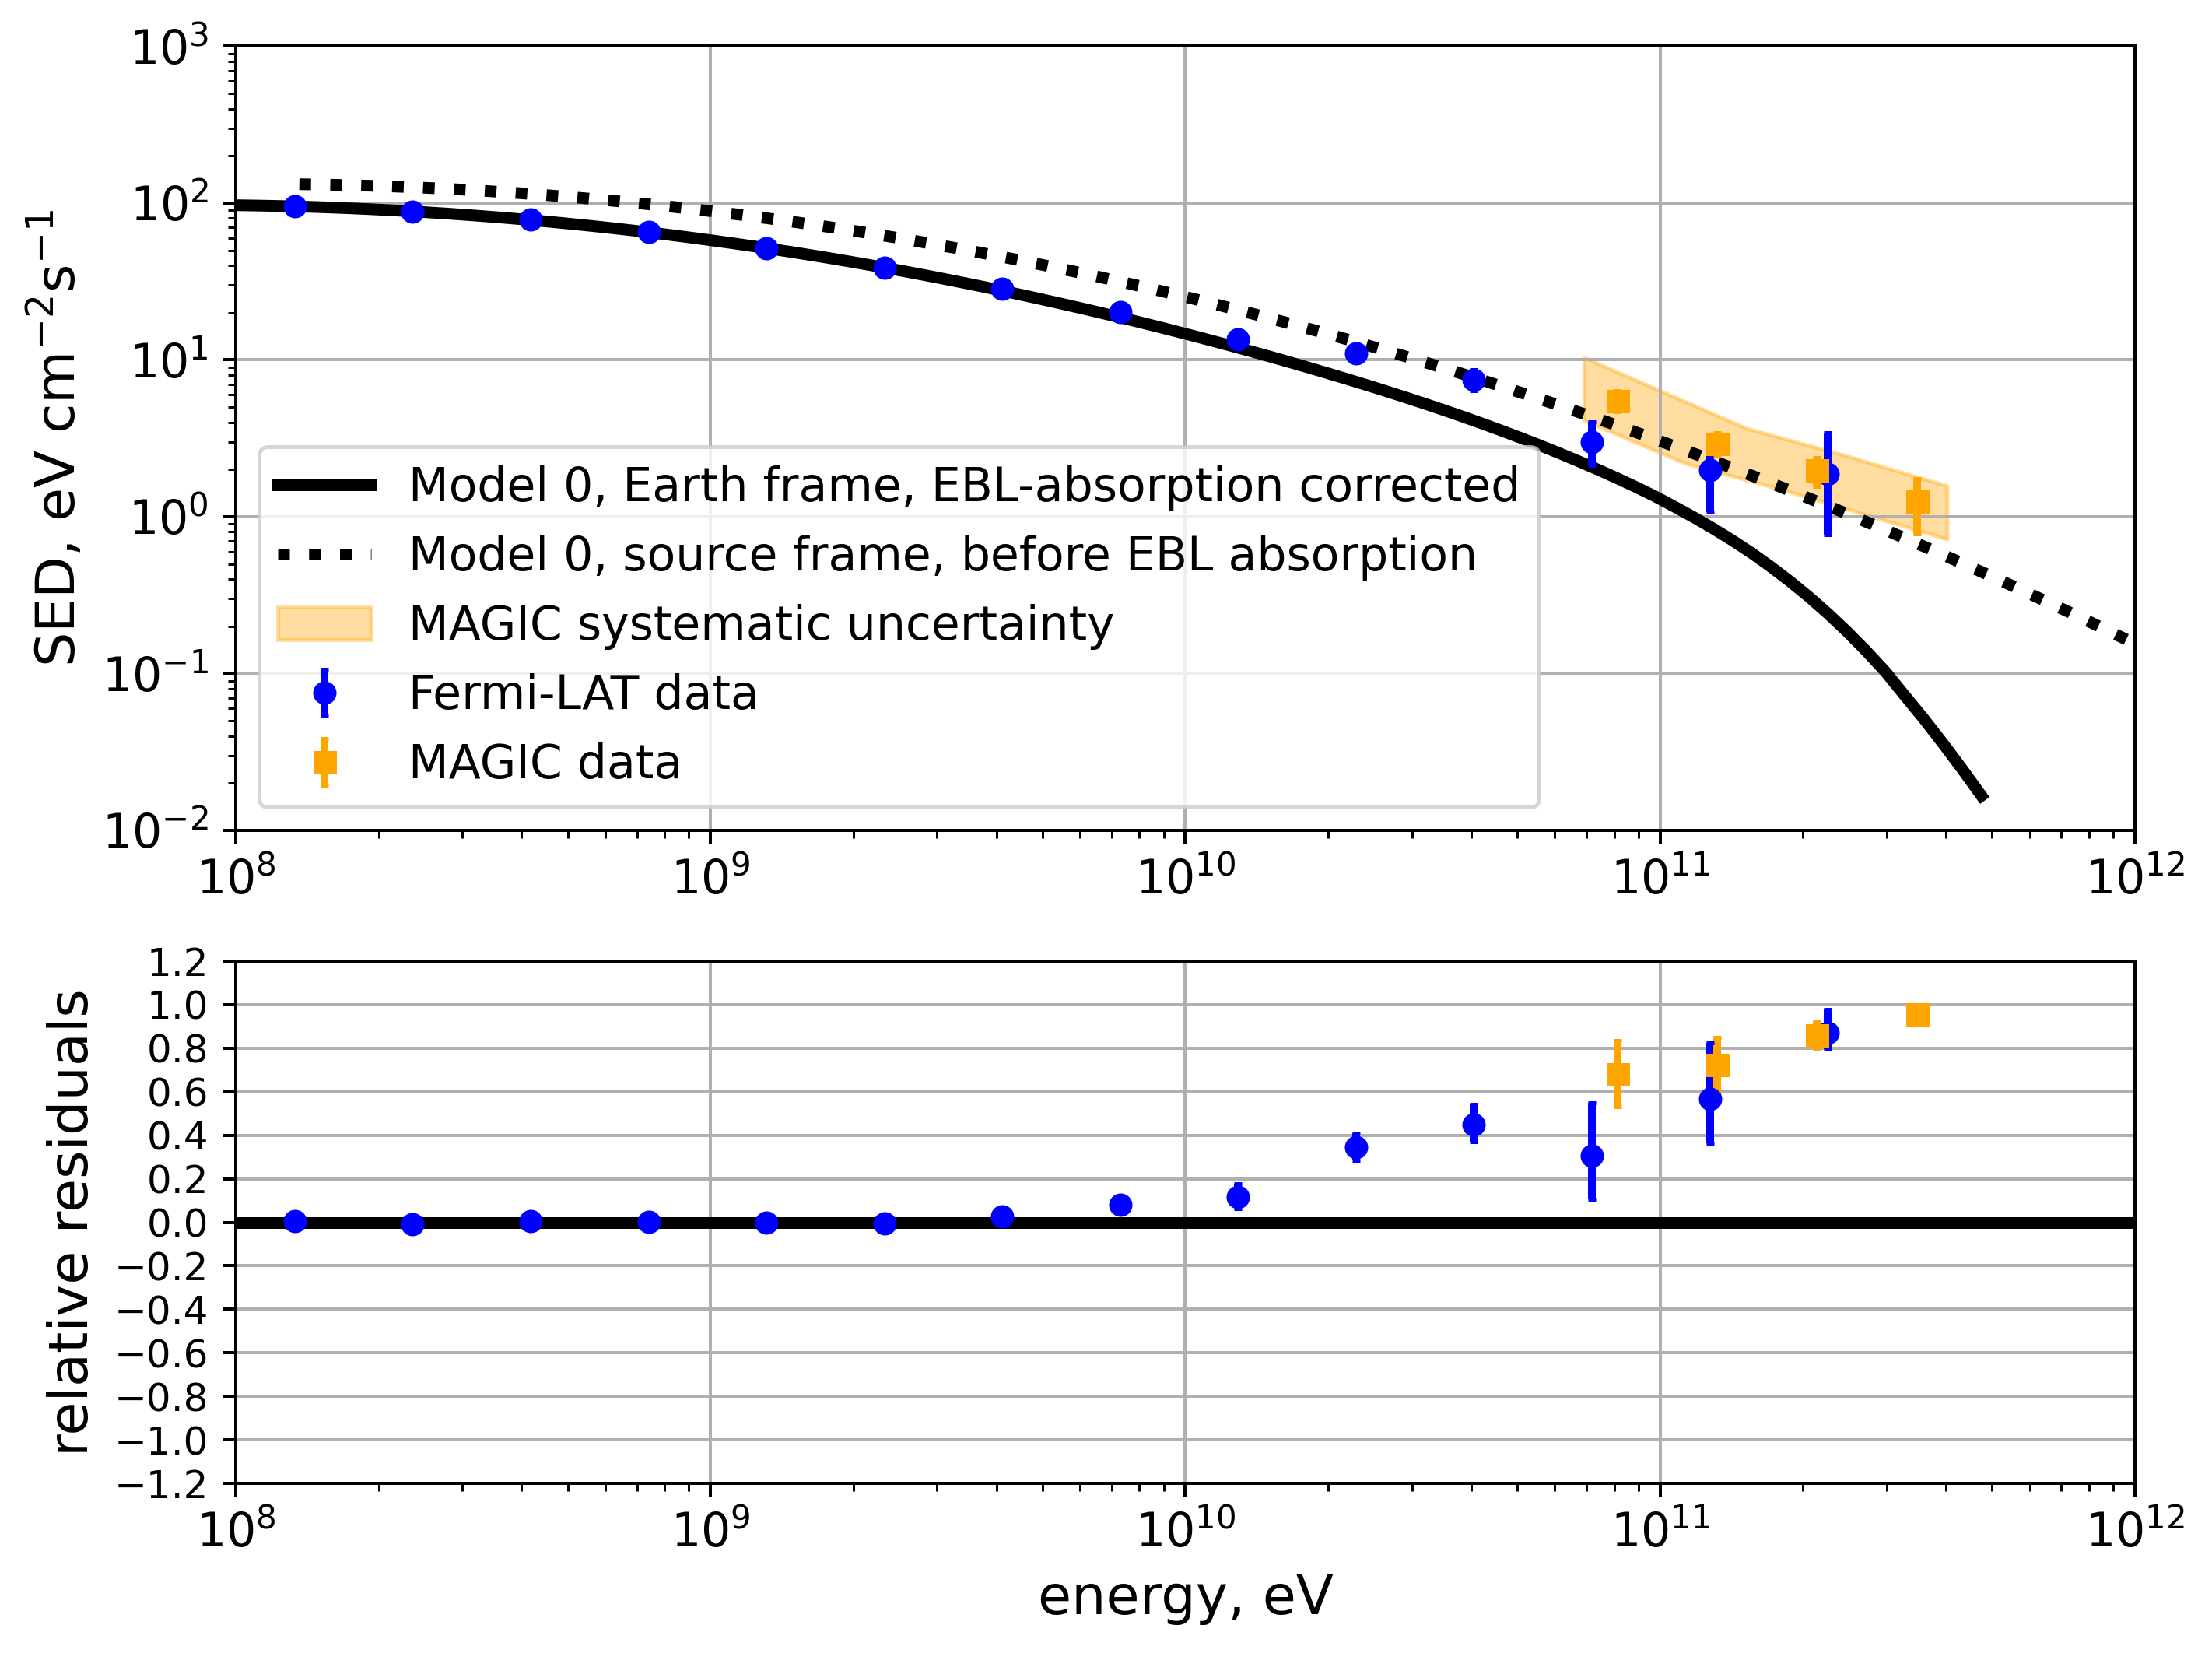

In [161]:
fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(8, 6),
                               sharex=False,
                               sharey=False,
                               dpi=360,
                               gridspec_kw={'height_ratios': [3, 2]})

filt_null_model = (en_observable < 5e+11)
ax1.plot(
    en_observable[filt_null_model], sed_null_model[filt_null_model],
    marker=None,
    linestyle='-',
    linewidth=3,
    color='k',
    label='Model 0, Earth frame, EBL-absorption corrected'
)

ax1.plot(
    en_source_null_model, sed_source_null_model,
    marker=None,
    linestyle=':',
    linewidth=3,
    color='k',
    zorder=2,
    label='Model 0, source frame, before EBL absorption'
)

ax1.errorbar(data_en_fermi, data_sed_fermi,
             yerr=yerr_fermi, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1, color='b', zorder=100.0,
             label='Fermi-LAT data')

ax1.errorbar(data_en_magic, data_sed_magic,
             yerr=yerr_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1, color='orange', zorder=100.0,
             label='MAGIC data')

ax1.fill_between(
    syst_magic_en_common,
    syst_magic_interpolated_down_function(syst_magic_en_common),
    syst_magic_interpolated_up_function(syst_magic_en_common),
    alpha=0.37,
    color='orange',
    label='MAGIC systematic uncertainty'
)
##############################################################################################################
ax1.set_ylabel('SED, ' + r'eV cm$^{-2}$s$^{-1}$', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1.0e+08, 1.0e+12)
ax1.set_ylim(1.0e-02, 1.0e+03)
ax1.grid()
ax1.legend(fontsize=12)# , loc='upper right')
##############################################################################################################
ax2.plot(np.logspace(8, 12), np.zeros((50, )),
         color='k',
         linewidth=3,
         linestyle='-')

ax2.errorbar(data_en_fermi, residual_fermi,
             yerr=yerr_residuals_fermi_relative, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1,
             color='b',
             label='Fermi-LAT')

ax2.errorbar(data_en_magic, residual_magic,
             yerr=yerr_residuals_magic_relative, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1,
             color='orange',
             label='MAGIC')

ax2.set_xlim(1.0e+08, 1.0e+12)
ax2.set_xscale('log')
ax2.set_ylim(-1.2, 1.2)
ax2.tick_params(axis='y', which='major', labelsize=10)
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.set_ylabel('relative residuals', fontsize=14)
ax2.set_xlabel('energy, eV', fontsize=14)
ax2.set_yticks(np.linspace(-1.2, 1.2, 13))

ax2.grid()

plt.tight_layout()
plt.show()
fig.savefig('test_figures/PKS1510-089/journal/fig3_v4.pdf')

# 2-component model

## Functions for gamma-ray spectrum calculations (from pp-interactions)

In [122]:
def sigma_pp_inelastic_cross_section(e):
    """
    proton-proton cross section:
    see http://dx.doi.org/10.1103/PhysRevD.74.034018
    (Kelner et al. (2006), eq. (79))
    """
    e = e.to(u.TeV)
    L = np.log(e.value)
    e_thr = (1.22e-03 * u.TeV).to(u.eV)
    return ((34.3 + 1.88 * L + 0.25 * L**2) *
            (1.0 - (e_thr / e)**4)**2 * 1.0e-24 * u.cm**2)

F_gamma_table = np.loadtxt("data/Processes-Timur/ProtonProtonGamma-1e16")
logx1 = np.log10(F_gamma_table[:, 0])
logy1 = np.log10(F_gamma_table[:, 1])
log_F_gamma_interpol = interpolate.interp1d(logx1, logy1,
                                            kind='linear',
                                            bounds_error=False,
                                            fill_value='extrapolate')

def F_gamma_interpol_aux(x):
    xl = np.log10(x)
    return ((10.0**log_F_gamma_interpol(xl)) / x**2)

def F_gamma_approx(E_gamma, E_proton):
    """
    Returns the spectrum of gamma rays from proton-proton interactions
    in frame of the scaling (1 / E_proton) approximation.
    """
    x = E_gamma / E_proton
    return (F_gamma_interpol_aux(x) / E_proton)

In [127]:
proton_energy = np.logspace(13.50, 14.77, 100) * u.eV
proton_spectrum = spec.power_law(
    proton_energy,
    2.0,
    norm=7e-19 * u.eV**(-1) * u.s**(-1) * u.cm**(-2),
    en_ref=en_ref * u.eV)
proton_column_density = 1.0e+23 * u.cm**(-2)
proton_tau = (proton_column_density *
              sigma_pp_inelastic_cross_section(proton_energy))
print("proton tau = ", proton_tau)
proton_spectrum_interacted = proton_spectrum * (1.0 -
                                                np.exp(-proton_tau))

proton tau =  [4.37756076 4.38823683 4.39895652 4.40971984 4.42052678 4.43137734
 4.44227154 4.45320935 4.4641908  4.47521586 4.48628456 4.49739687
 4.50855282 4.51975239 4.53099558 4.5422824  4.55361285 4.56498692
 4.57640461 4.58786593 4.59937088 4.61091945 4.62251165 4.63414747
 4.64582692 4.65754999 4.66931669 4.68112701 4.69298096 4.70487853
 4.71681973 4.72880455 4.740833   4.75290508 4.76502078 4.7771801
 4.78938306 4.80162963 4.81391983 4.82625366 4.83863111 4.85105219
 4.86351689 4.87602522 4.88857717 4.90117275 4.91381195 4.92649478
 4.93922124 4.95199132 4.96480502 4.97766235 4.99056331 5.00350789
 5.0164961  5.02952793 5.04260338 5.05572247 5.06888517 5.08209151
 5.09534147 5.10863505 5.12197226 5.13535309 5.14877755 5.16224563
 5.17575734 5.18931268 5.20291164 5.21655423 5.23024044 5.24397027
 5.25774374 5.27156082 5.28542153 5.29932587 5.31327383 5.32726542
 5.34130064 5.35537948 5.36950194 5.38366803 5.39787774 5.41213108
 5.42642805 5.44076864 5.45515285 5.4695807  5.48

In [128]:
folder_hybrid_gamma = "test54_primary_gamma_field_30000_eps_thr=1e+05eV_with_losses_below_threshold_7e+07---1e+14eV_photon_max=None"
energy_bins_fit_hybrid_gamma_from_protons = np.logspace(8, 14, 49)
primary_energy_bins_fit_hybrid_gamma_from_protons = np.logspace(
    np.log10(1.0e+10),
    np.log10(1.0e+14),
    49
)
en_primary_min_in_mc_gamma_from_protons = 7.0e+07
en_primary_max_in_mc_gamma_from_protons = 1.0e+14
number_of_particles_hybrid_gamma_from_protons = (
    30_000 *
    np.log(primary_energy_bins_fit_hybrid_gamma_from_protons[-1] /
           primary_energy_bins_fit_hybrid_gamma_from_protons[0]) /
    np.log(en_primary_max_in_mc_gamma_from_protons /
           en_primary_min_in_mc_gamma_from_protons)
)

In [129]:
gamma_from_protons_energy = np.logspace(np.log10(primary_energy_bins_fit_hybrid_gamma_from_protons[0]),
                                        np.log10(primary_energy_bins_fit_hybrid_gamma_from_protons[-1]),
                                        100) * u.eV
gamma_from_protons_spectrum = (np.array(list(map(
    lambda z: simps(F_gamma_approx(z.value,
                                   proton_energy.value) *
                    proton_spectrum_interacted.value,
                    proton_energy.value),
    gamma_from_protons_energy))) *
    F_gamma_approx(gamma_from_protons_energy,
                   proton_energy[0]).unit *
    proton_spectrum[0].unit *
    proton_energy[0].unit)

In [130]:
f_aux_gamma_from_protons_spectrum = interpolate.interp1d(
    np.log10(gamma_from_protons_energy.value),
    np.log10(gamma_from_protons_spectrum.value),
    kind='linear',
    bounds_error=False,
    fill_value='extrapolate'
)

def gamma_from_protons_spectrum_interpolated(energy, c):
    return(10.0**(f_aux_gamma_from_protons_spectrum(np.log10(
        energy
    ))) * c)

## Function to fit the data with the 2-component model

In [131]:
def fit_data_with_monte_carlo(f, x_data, y_data, y_sigma, p0,
                              number_of_hidden_parameters=0):
    popt, pcov = curve_fit(f, x_data, y_data,
                           p0=p0, sigma=y_sigma,
                           absolute_sigma=True,
                           check_finite=False)  # , bounds=bounds)
    print("----------------------------------------------------------")
    print("The following parameters have been obtained:")
    for i, parameter in enumerate(popt):
        print(
            "parameter number {:d} = {:e} +/- {:e}".format(
                i, popt[i], np.sqrt(np.diag(pcov)[i])))
    ####################################################################
    # calculate chi^2
    data_predicted_from_fit = f(x_data, *popt)
    chi_sq = np.sum((y_data - data_predicted_from_fit)**2 / y_sigma**2)
    ndof = (y_data.shape[0] - len(popt) - 1) - \
        number_of_hidden_parameters
    print('ndof = {:d}'.format(ndof))
    print("chi_sq / n.d.o.f. = {:f}".format(
        chi_sq /
        ndof)
    )
    return (popt, np.sqrt(np.diag(pcov)), chi_sq, ndof)

## Load data from the Monte-Carlo simulations

In [132]:
hist_precalc_hybrid_gamma_from_protons = make_sed_from_monte_carlo_cash_files(
    folder_hybrid_gamma,
    energy_bins_fit_hybrid_gamma_from_protons,  # array-like
    primary_energy_bins=primary_energy_bins_fit_hybrid_gamma_from_protons,
    cascade_type_of_particles='all',
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    new_spectrum=None,
    new_params=None,
    original_keyargs={},
    new_keyargs={},
    reweight_array='primary',
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    particles_of_interest='gamma',  # or 'electron'
    density=False,
    verbose=False,
    output='histogram_2d_precalculated',
    device='cpu'
)

## 2-component model SED function

In [133]:
def model_sed_from_monte_carlo_hybrid_gamma_from_protons(
    en_observable,
    norm_gamma_from_protons,
    alpha_null,
    beta_null,
    norm_null,
    en_ref=en_ref,
    energy_bins_mc=energy_bins_fit_hybrid_gamma_from_protons,
    primary_energy_bins_mc=primary_energy_bins_fit_hybrid_gamma_from_protons,
    redshift=z,
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    histogram_2d_precalculated=hist_precalc_hybrid_gamma_from_protons
):
    e_cascade, sed_cascade = make_SED(
        None,
        energy_bins_mc,
        None,
        primary_energy_bins=primary_energy_bins_mc,
        original_spectrum=original_spectrum,
        original_params=original_params,
        new_spectrum=gamma_from_protons_spectrum_interpolated,
        new_params=[norm_gamma_from_protons, ],
        original_keyargs={},
        new_keyargs={},
        reweight_array='primary',
        number_of_particles=number_of_particles,
        density=False,
        histogram_2d_precalculated=histogram_2d_precalculated,
        old=False
    )
    sed_cascade[sed_cascade <= 0] = 1.0e-40
    en_source = en_observable * (1.0 + redshift)
    sed_cascade = spec.to_current_energy(
        en_source,
        e_cascade, sed_cascade
    )
    ###################################################################
    sed_null = en_source**2 * my_spec(en_source,
                                      alpha_null, beta_null, norm_null)
    ###################################################################
    sed = sed_cascade + sed_null
    sed = sed * np.exp(-ebl.tau_gilmore(en_observable * u.eV,
                                        redshift))
    sed = sed / (1.0 + redshift)  # AHNTUNG ATTENTION !!!
    return sed

## Fit the 2-component model SED to the data

In [134]:
p0_hybrid_gamma_from_protons = [1.0, # norm_gamma_from_protons,
                                2.725828e+00, # alpha_null
                                7.977361e-02, # beta_null
                                2.544626e-19] # norm_null
popt_hybrid_gamma_from_protons, perr_hybrid_gamma_from_protons, chisq_hybrid_gamma_from_protons, ndof_hybrid_gamma_from_protons = fit_data_with_monte_carlo(
    model_sed_from_monte_carlo_hybrid_gamma_from_protons,
    x_data, y_data, y_sigma,
    p0_hybrid_gamma_from_protons,
    number_of_hidden_parameters=0)
sed_hybrid_gamma_from_protons = model_sed_from_monte_carlo_hybrid_gamma_from_protons(
    en_observable,
    *popt_hybrid_gamma_from_protons
)
gamma_from_protons_sed = (gamma_from_protons_spectrum *
                          gamma_from_protons_energy**2 *
                          popt_hybrid_gamma_from_protons[0])

----------------------------------------------------------
The following parameters have been obtained:
parameter number 0 = 1.120028e+00 +/- 2.479796e-01
parameter number 1 = 2.767886e+00 +/- 2.818952e-02
parameter number 2 = 8.552830e-02 +/- 4.767030e-03
parameter number 3 = 2.350485e-19 +/- 9.734270e-21
ndof = 13
chi_sq / n.d.o.f. = 0.846212
popt_hybrid_gamma_from_protons =  [1.12002796e+00 2.76788571e+00 8.55283035e-02 2.35048457e-19]


In [138]:
p_value_hybrid_gamma_from_protons = stats.chi2.sf(
    chisq_hybrid_gamma_from_protons,
    df=ndof_hybrid_gamma_from_protons
)
print("p_value_hybrid_gamma_from_protons = {:.4f}".format(
    p_value_hybrid_gamma_from_protons
))
significance_hybrid_gamma_from_protons = spec.get_significance_2_tailed(
    p_value_hybrid_gamma_from_protons
)
print("significance_hybrid_gamma_from_protons = {:.2f} sigma".format(
    significance_hybrid_gamma_from_protons
))

p_value_hybrid_gamma_from_protons = 0.6108
significance_hybrid_gamma_from_protons = 0.51 sigma


## Obtain the second component (from the Monte-Carlo simulation) with the best-fit spectrum parameters

In [139]:
e_all_mc_gamma_from_protons, sed_all_mc_gamma_from_protons = make_sed_from_monte_carlo_cash_files(
    folder_hybrid_gamma,
    energy_bins_fit_hybrid_gamma_from_protons,  # array-like
    primary_energy_bins=primary_energy_bins_fit_hybrid_gamma_from_protons,
    cascade_type_of_particles='all',
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    new_spectrum=gamma_from_protons_spectrum_interpolated,
    new_params=[popt_hybrid_gamma_from_protons[0], ],
    original_keyargs={},
    new_keyargs={},
    reweight_array='primary',
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    particles_of_interest='gamma',  # or 'electron'
    density=False,
    verbose=False,
    output='sed',
    device='cpu'
)
e_all_mc_gamma_from_protons_observable = (e_all_mc_gamma_from_protons /
                                          (1.0 + z))
sed_all_mc_gamma_from_protons_observable = (
    sed_all_mc_gamma_from_protons /
    (1.0 + z) *
    np.exp(-ebl.tau_gilmore(
        e_all_mc_gamma_from_protons_observable * u.eV,
        z)
    ))

## Obtain the first component (from the Monte-Carlo simulation) with the best-fit spectrum parameters

In [143]:
sed_null_model2 = model0_SED(en_observable, *[*p0_hybrid_gamma_from_protons[1:], r_blr.value])
en_source_null_model2 = en_observable * (1.0 + z)
sed_source_null_model2 = (my_spec(en_source_null_model2,
                                 *p0_hybrid_gamma_from_protons[1:]) *
                          en_source_null_model2**2)

## Residuals

In [164]:
sed_hybrid_gamma_from_protons_at_fermi = spec.to_current_energy(data_en_fermi,
                                                                en_observable,
                                                                sed_hybrid_gamma_from_protons)
residual_fermi2 = (data_sed_fermi - sed_hybrid_gamma_from_protons_at_fermi) / data_sed_fermi

In [165]:
yerr_residuals_fermi_relative2 = [sed_hybrid_gamma_from_protons_at_fermi / data_sed_fermi**2 * yerr_fermi[0],
                                  sed_hybrid_gamma_from_protons_at_fermi / data_sed_fermi**2 * yerr_fermi[1]]
yerr_residuals_fermi_relative2

[array([0.00673737, 0.00693119, 0.00743416, 0.00907381, 0.01206491,
        0.01757388, 0.02585326, 0.03983384, 0.06783872, 0.08470768,
        0.13236939, 0.42490748, 0.58234586, 0.32008901]),
 array([0.00679952, 0.00693029, 0.00752213, 0.00920392, 0.01224106,
        0.0178199 , 0.02667374, 0.04164526, 0.07234242, 0.09226013,
        0.14946588, 0.50814865, 0.74817619, 0.44784886])]

In [169]:
sed_hybrid_gamma_from_protons_at_fermi_at_magic = spec.to_current_energy(
    data_en_magic,
    en_observable,
    sed_hybrid_gamma_from_protons
)
residual_magic2 = (data_sed_magic - sed_hybrid_gamma_from_protons_at_fermi_at_magic) / data_sed_magic

In [170]:
yerr_residuals_magic_relative2 = [(sed_hybrid_gamma_from_protons_at_fermi_at_magic / data_sed_magic**2 *
                                  ((yerr_magic[0])**2 + (magic_syst_error(data_en_magic))**2)**0.5),
                                 (sed_hybrid_gamma_from_protons_at_fermi_at_magic / data_sed_magic**2 *
                                  ((yerr_magic[1])**2 + (magic_syst_error(data_en_magic))**2)**0.5)]

## Plotting the results

In [173]:
font_delta = 4

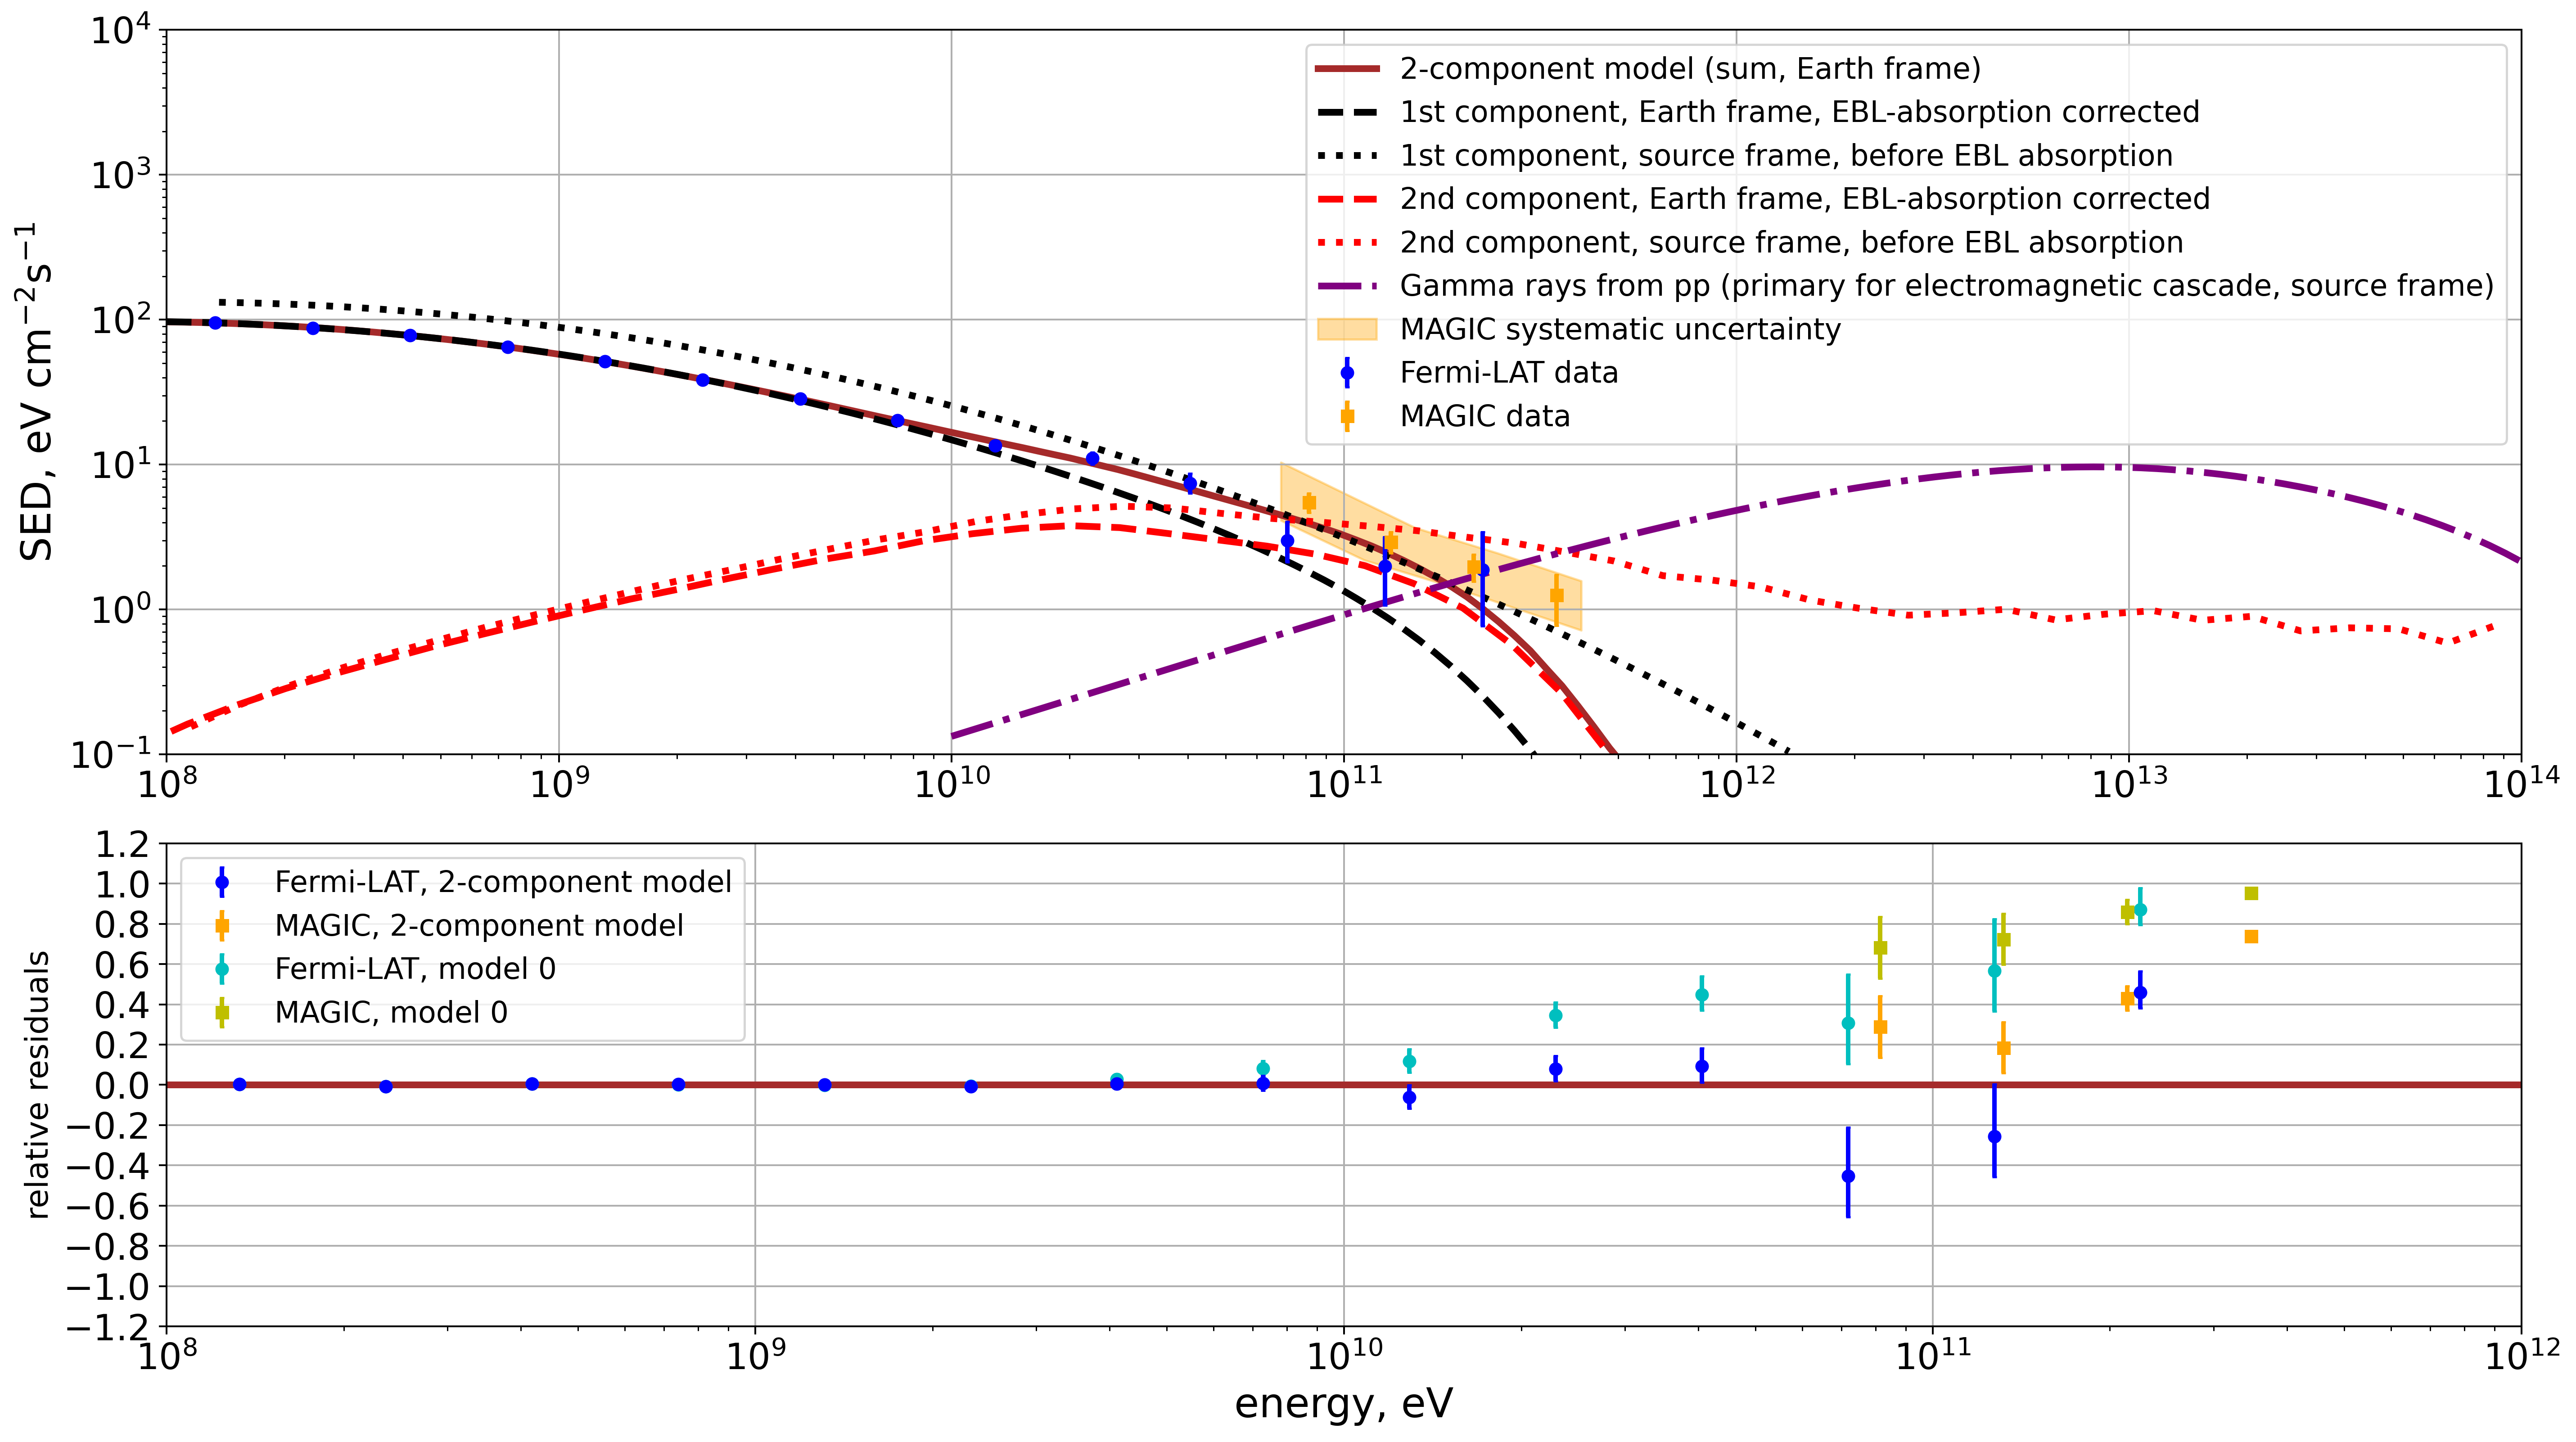

In [181]:
fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(16, 9),
                               sharex=False,
                               sharey=False,
                               dpi=360,
                               gridspec_kw={'height_ratios': [3, 2]})

ax1.plot(
    en_observable, sed_hybrid_gamma_from_protons,
    marker=None,
    linestyle='-',
    linewidth=3,
    color='brown',
    label='2-component model (sum, Earth frame)'
)

filt_null_model2 = (en_observable < 5e+11)
ax1.plot(
    en_observable[filt_null_model2], sed_null_model2[filt_null_model2],
    marker=None,
    linestyle='--',
    linewidth=3,
    color='k',
    label='1st component, Earth frame, EBL-absorption corrected'
)

ax1.plot(
    en_source_null_model2, sed_source_null_model2,
    marker=None,
    linestyle=':',
    linewidth=3,
    color='k',
    zorder=2,
    label='1st component, source frame, before EBL absorption'
)

ax1.plot(
    e_all_mc_gamma_from_protons_observable, sed_all_mc_gamma_from_protons_observable,
    marker=None,
    linestyle='--',
    linewidth=3,
    color='r',
    label='2nd component, Earth frame, EBL-absorption corrected'
)

ax1.plot(
    e_all_mc_gamma_from_protons, sed_all_mc_gamma_from_protons,
    marker=None,
    linestyle=':',
    linewidth=3,
    color='r',
    label='2nd component, source frame, before EBL absorption'
)

ax1.plot(
        gamma_from_protons_energy, gamma_from_protons_sed,
        marker=None,
        linestyle='-.',
        linewidth=3,
        color='purple',
        zorder=2,
        label='Gamma rays from pp (primary for electromagnetic cascade, source frame)'
    )

ax1.errorbar(data_en_fermi, data_sed_fermi,
             yerr=yerr_fermi, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1, color='b', zorder=100.0,
             label='Fermi-LAT data')

ax1.errorbar(data_en_magic, data_sed_magic,
             yerr=yerr_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1, color='orange', zorder=100.0,
             label='MAGIC data')

ax1.fill_between(
    syst_magic_en_common,
    syst_magic_interpolated_down_function(syst_magic_en_common),
    syst_magic_interpolated_up_function(syst_magic_en_common),
    alpha=0.37,
    color='orange',
    label='MAGIC systematic uncertainty'
)
##############################################################################################################
ax1.set_ylabel('SED, ' + r'eV cm$^{-2}$s$^{-1}$', fontsize=14 + font_delta)
ax1.tick_params(axis='both', which='major', labelsize=12 + font_delta)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1.0e+08, 1.0e+14)
ax1.set_ylim(1.0e-01, 1.0e+04)
ax1.grid()
ax1.legend(fontsize=12 + 1)# , loc='upper right')
##############################################################################################################
ax2.plot(np.logspace(8, 12), np.zeros((50, )),
         color='brown',
         linewidth=3,
         linestyle='-')

ax2.errorbar(data_en_fermi, residual_fermi2,
             yerr=yerr_residuals_fermi_relative, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1,
             color='b',
             label='Fermi-LAT, 2-component model',
             zorder=400)

ax2.errorbar(data_en_magic, residual_magic2,
             yerr=yerr_residuals_magic_relative, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1,
             color='orange',
             label='MAGIC, 2-component model',
             zorder=300)

ax2.errorbar(data_en_fermi, residual_fermi,
             yerr=yerr_residuals_fermi_relative, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1,
             color='c',
             label='Fermi-LAT, model 0')

ax2.errorbar(data_en_magic, residual_magic,
             yerr=yerr_residuals_magic_relative, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=5,
             errorevery=1, capthick=1,
             color='y',
             label='MAGIC, model 0')

ax2.set_xlim(1.0e+08, 1.0e+12)
ax2.set_xscale('log')
ax2.set_ylim(-1.2, 1.2)
ax2.tick_params(axis='y', which='major', labelsize=12 + font_delta)
ax2.tick_params(axis='x', which='major', labelsize=12 + font_delta)
ax2.set_ylabel('relative residuals', fontsize=14)
ax2.set_xlabel('energy, eV', fontsize=14 + font_delta)
ax2.set_yticks(np.linspace(-1.2, 1.2, 13))
ax2.legend(fontsize=12 + 1)# , loc='upper right')
ax2.grid()

plt.tight_layout()
plt.show()
# fig.savefig('test_figures/PKS1510-089/journal/fig4_v2.pdf')